## Пример: House Sales in King County, USA <a name="house_case"></a>

Будем пробовать различные методы, чтобы научиться определять цену на недвижимость.  
Данные взяты с [одноименного соревнования](https://www.kaggle.com/harlfoxem/housesalesprediction) на Kaggle.  

Данные содержат информацию о продажах индивидуальных домов в период с мая 2014 года по май 2015 в округе Кинг, штат Вашингтон, США.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
style.use('seaborn')

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

pd.set_option('display.max_columns', 25)

In [ ]:
house_data = pd.read_csv("kc_house_data.csv")

Давайте сымитируем ситуацию, когда заказчик скрыл часть данных.

In [ ]:
holdout = house_data.sample(2000) # рандомная скрытая часть
house_data = house_data.loc[~house_data.index.isin(holdout.index)] #наш датасет без скрытой части

И будем дальше работать с house_data, как будто части holdout у нас никогда не было

### Комментарии по признакам

__price__ - целевая переменная (y).

__id__ - уникален для каждого объекта, необходимо удалить из выборки.

Посмотрим еще на три признака: 
* __sqft_living__ - общая площадь дома
* __sqft_above__ - общая площадь наземной части дома
* __sqft_basement__ - общая площадь подземного части дома  
  
Здравый смысл нам подсказывает, что эти признаки линейно связаны, а именно:  
$$sqft\_basement = sqft\_living - sqft\_above$$
  

In [ ]:
print(house_data.sqft_basement == (house_data.sqft_living - house_data.sqft_above))

0        True
1        True
2        True
3        True
4        True
         ... 
21608    True
21609    True
21610    True
21611    True
21612    True
Length: 19613, dtype: bool


Поэтому признак sqft_basement можно удалить, оставив остальные два.

Признаки **lat** и **long** неоднозначные, но оставим их - вдруг помогут учесть географическое расположение домов. 

In [ ]:
house_data[['lat', 'long']].describe()

,lat,long
count,19613.000000,19613.000000
mean,47.560048,-122.213687
std,0.138932,0.140611
min,47.155900,-122.519000
25%,47.470500,-122.328000
50%,47.572000,-122.229000
75%,47.678200,-122.124000
max,47.777600,-121.316000


### Предобработка данных

Удалим явным образом не подходящие признаки.

In [ ]:
data = house_data.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)

## Обучающая и тестовая выборки <a name="train_test"></a>

Для тестирования для начала применим простой метод - разделите датасет на две части: на одной будем обучать, на другой оценивать качество модели.  


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = data['price']
X = data.iloc[:,1:] # оставили все колонки без price

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

## K Nearest Neighbors <a name="knn"></a>

Будем обучаться на данных X_train. Нормализуйте X_train и добавьте KNeighborsRegressor с параметром n_neigbors = 5. Посчитайте чему равна MSE.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


#reg = make_pipeline ()
knn = KNeighborsRegressor(n_neighbors=5)
X_scaled = MinMaxScaler().fit_transform(X_train)
knn.fit(X_scaled, y_train)
y_pred = knn.predict(X_scaled)
print(mean_squared_error(y_pred, y_train))
#mse =
#Ваш код здесь

17880231655.52731


Теперь в цикле подберите переберите параметр n_neigbors и по графику ошибок mse определите оптимальное значение

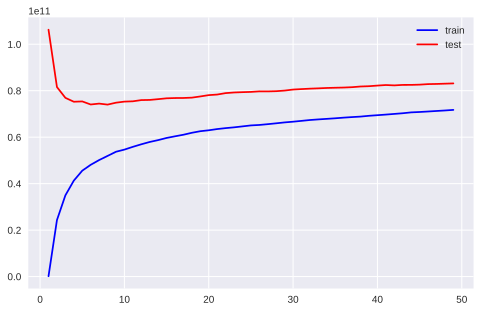

In [ ]:
neighbors = range(1, 50)
errors_train = []
errors_test = []

for k in neighbors:
    #Ваш код здесь
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    errors_train.append(mean_squared_error(knn.predict(X_train), y_train))
    errors_test.append(mean_squared_error(knn.predict(X_test), y_test))
    pass
    
    
plt.plot(neighbors, errors_train, color='blue', label='train')
plt.plot(neighbors, errors_test, color='red', label='test')
plt.legend()


Постройте такой же график, только для median_absolute_error. Совпадают ли оптимальные значения n_neigbors для 2 типов ошибок?

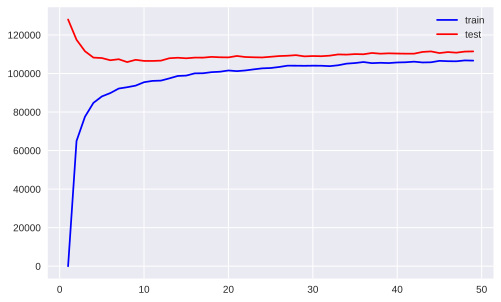

In [ ]:
from sklearn.metrics import median_absolute_error

#Ваш код здесь
neighbors = range(1, 50)
errors_train = []
errors_test = []

for k in neighbors:
    #Ваш код здесь
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    errors_train.append(median_absolute_error(knn.predict(X_train), y_train))
    errors_test.append(median_absolute_error(knn.predict(X_test), y_test))
    pass
    
    
plt.plot(neighbors, errors_train, color='blue', label='train')
plt.plot(neighbors, errors_test, color='red', label='test')
plt.legend()

## Подбор k на кросс-валидации

Теперь с помощью GridSearchCV (cv=5) переберите параметр n_neighbors еще раз и выведите best_score_ и best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

param_grid = [
    {'kneighborsregressor__n_neighbors': range(1,50)},
]

reg = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor() 
)

grid_search = GridSearchCV(reg, param_grid, cv=5, return_train_score=True) #Ваш код здесь, в параметры GridSearchCV() добавьте еще один, return_train_score=True
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7765889495886527
{'kneighborsregressor__n_neighbors': 7}


Теперь посомотрим как менялась ошибка на обучающей и тестовой части по время обучения, нарисуйте на графике 2 кривые  grid_search.cv_results_['mean_train_score'] и grid_search.cv_results_['mean_test_score']

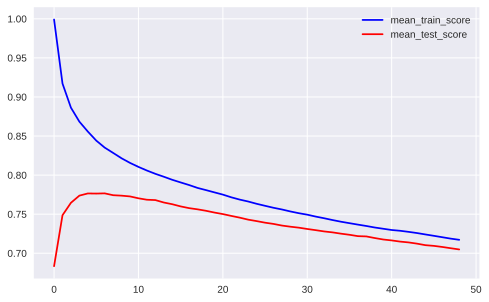

In [ ]:
#Ваш код здесь
plt.plot(grid_search.cv_results_['mean_train_score'], color='blue', label='mean_train_score')
plt.plot(grid_search.cv_results_['mean_test_score'], color='red', label='mean_test_score')
plt.legend()

Теперь попробуем перебрать все возможные параметры KNeighborsRegressor. Добавьте в param_grid переменные kneighborsregressor__weights,
kneighborsregressor__metric(почитайте в документации какие значения она может принимать). Выведите best_score_ и best_params_


In [ ]:
#Ваш код здесь
param_grid = [
    {'kneighborsregressor__n_neighbors': range(1,50)},
    {'kneighborsregressor__weights': ['uniform', 'distance']},
    {'kneighborsregressor__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']}
]

reg = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor() 
)

grid_search = GridSearchCV(reg, param_grid, cv=5, return_train_score=True) 
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7918773149937699
{'kneighborsregressor__metric': 'manhattan'}


И наконец последний этап, контрольная проверка. Вспомним что у нас была скрытая выборка holdout. Теперь c ней нужно проделать те же преобразования, что и c обучающей выборкой - удалить лишние колонки, а потом применить grid_search.best_estimator_.predict) - получим предсказанные цены на скрытой части данных. 

In [ ]:
#Ваш код здесь
holdout_data = holdout.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)
y = holdout_data['price']
X = holdout_data.iloc[:,1:] # оставили все колонки без price
X_pred = grid_search.best_estimator_.predict(X)

Остается только сравнить предсказания с истинными значениями holdout['price'] и вывести mse. 

In [ ]:
#Ваш код здесь
print(mean_squared_error(X_pred, y))


35603458350.72626


Если модель обучилась хорошо, то ошибка на holdout выборке будет примерно равна ошибка на нашей собственной тестовой части, т.е. grid_search.best_score_

## Дополнительное задание для любознательных

Повторите последний этам обучения gridsearch, в param_grid подставьте только по одному оптимальному значению из grid_search.best_params_, а вместо cv = 5 подставьте cv = LeaveOneOut(). Засеките время работы алгоритма.
Улучшился ли результат?

In [ ]:
%%time

param_grid = [
    {'kneighborsregressor__n_neighbors': range(7, 8)},
    {'kneighborsregressor__metric': ['manhattan']}
]

reg = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor() 
)

grid_search = GridSearchCV(reg, param_grid, cv=LeaveOneOut(), return_train_score=True) 
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetri

KeyboardInterrupt: ignored